<a href="https://colab.research.google.com/github/DerekHickey6/G-Colab-PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing pytorch and setting up device agnostic code


In [4]:
import torch
from torch import nn

# Setup Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Dataset is a subset of TorchVision Food101 Dataset
- 3 classes, only 10% of the images
- 1000 each class (75 training, and 25 testing)

Start small scale, then scale up when necessary.
Speed up how fast we experiment

In [10]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image forlder doesn't exist, download and prepare
if image_path.is_dir():
  print(f"{image_path} directiory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,
                   exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, sushi data")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directiory already exists... skipping download
Unzipping pizza, steak, sushi data


## 2. Becoming one with the data (data preparation and data exploration)

In [12]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning it's contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'


In [13]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. Get all of the image paths
2. Pick a random image path using Pythons random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. We'll show the image and print metadata

Random image path: data/pizza_steak_sushi/test/sushi/2190404.jpg
Image class: sushi
Image height: 512
Image width: 512


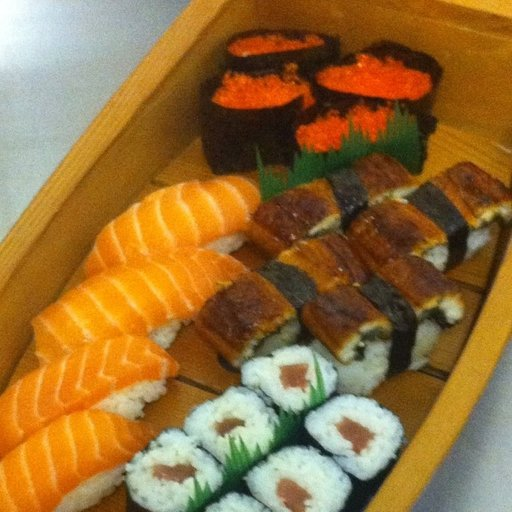

In [65]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name (image class is the name of the directory)
image_class = random_image_path.parent.stem

# 4. Open the image using PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

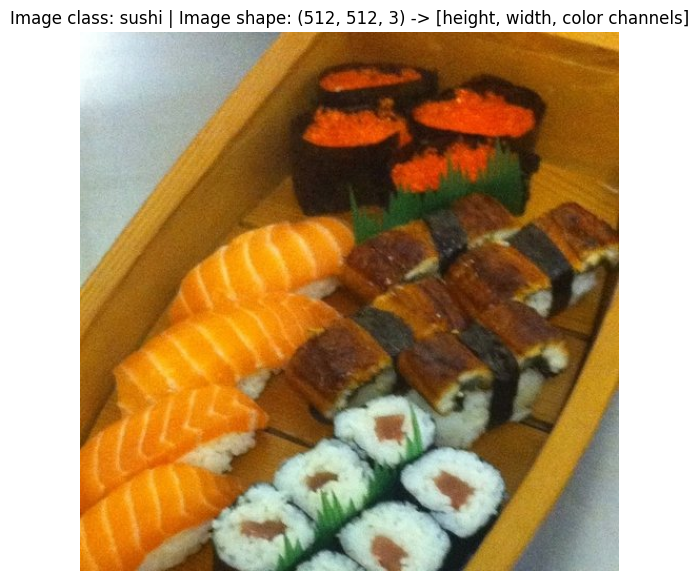

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

## 3. Transforming data

1. Turn target data into trensors (numerical representation of images)
2. Turn it unto `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`


In [71]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [72]:
# Write a transform for image
data_transform = transforms.Compose([     ## or nn.Sequential
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

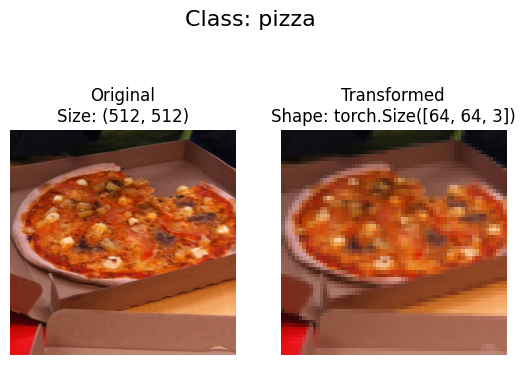

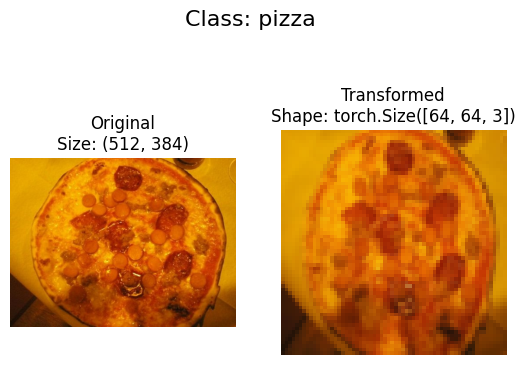

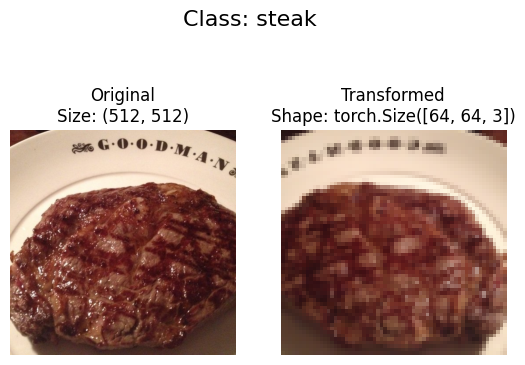

In [82]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  """Selects random images from a path of images and loads/transforms them, then plots the orginal vs transformed"""
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)    # Permute changes the order for (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

